# Model selection & comparison

_Alex Malz (LINCC@CMU)_
_LSSTC Data Science Fellowship Program_

In [65]:
from astropy import cosmology as apcosmo
from astropy import constants as apconst
import numpy as np
import scipy.stats as sps

In [67]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Overview

Let's try to infer the cosmological parameters from redshifts and distances to Type Ia SNe.
This problem is adapted from [Supernova Cosmology Inference with Probabilistic Photometric Redshifts (SCIPPR)](https://github.com/aimalz/scippr), specifically the [forward model](https://github.com/aimalz/scippr/blob/master/code/demos/Simulation.ipynb) and [posterior inference](https://github.com/aimalz/scippr/blob/master/code/demos/Inference.ipynb) procedures.

### Data

First, we need to make some mock data!

In [3]:
# Planck values
prior_H0 = sps.norm(loc=67.4, scale=0.5)
prior_Om0 = sps.norm(loc=0.315, scale=0.007)
true_H0 = prior_H0.rvs()
true_Om0 = prior_Om0.rvs()
print(f'$H_{{0}}^{{true}}=${true_H0}, $\Omega_{{m}}^{{true}}=${true_Om0}')
true_cosmo = apcosmo.FlatLambdaCDM(H0=true_H0, Om0=true_Om0)

$H_{0}^{true}=$67.28943793633715, $\Omega_{m}^{true}=$0.3155264443173761


In [4]:
# def nz_func(z, c=0.3):
#     return 1./(2.*c) * (z/c)**2 * np.exp(-1. * z/c)
nz_true = sps.gamma(3, scale=0.3)
zs_true = nz_true.rvs(100)

Text(0.5, 1.0, 'SNIa redshift distribution')

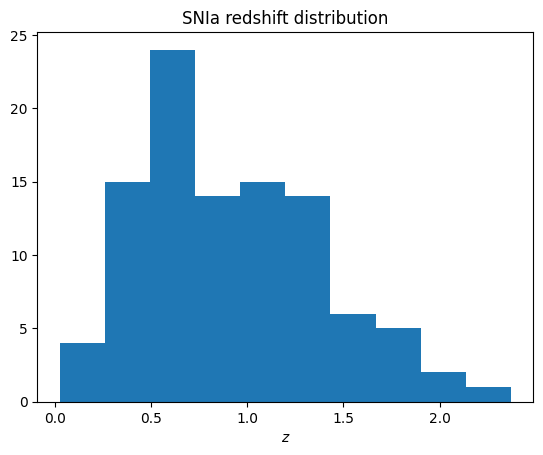

In [5]:
plt.hist(zs_true);
plt.xlabel(r'$z$')
plt.title('SNIa redshift distribution')

In [6]:
mus_true = true_cosmo.distmod(zs_true).value

Text(0.5, 1.0, 'true Hubble diagram')

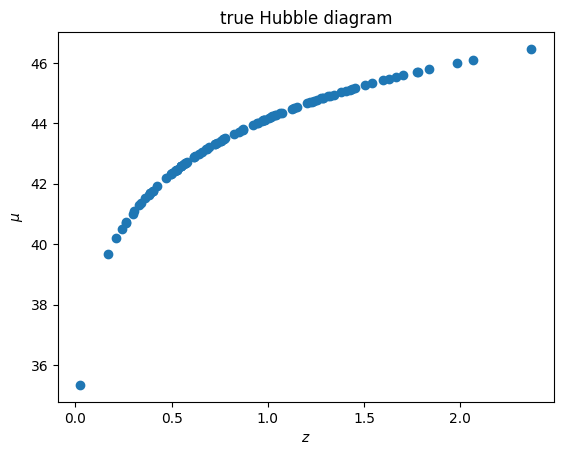

In [7]:
plt.scatter(zs_true, mus_true)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.title('true Hubble diagram')

There's some code to complicate things by allowing errors on the "independent" variable, which isn't really so independent in this case, but it would mean that the frequentist metrics don't apply, so let's leave it out for now.

In [8]:
# bias_lsst = 0.003
# scatter_lsst = 0.02
# outlier_lsst = 0.1

z_min = 0.
z_max = 3.
# z_norm_low_true = (z_min - zs_true - bias_lsst * (1 + zs_true)) / (scatter_lsst * (1+zs_true))
# z_norm_high_true = (z_max - zs_true - bias_lsst * (1 + zs_true)) / (scatter_lsst * (1+zs_true))
# zs_pdf_true = sps.truncnorm(z_norm_low_true, z_norm_high_true, loc=zs_true+bias_lsst, scale=scatter_lsst*(1+zs_true))
# zs_obs = zs_pdf_true.rvs()
# z_norm_low_obs = (z_min - zs_obs - bias_lsst * (1 + zs_obs)) / (scatter_lsst * (1+zs_obs))
# z_norm_high_obs = (z_max - zs_obs - bias_lsst * (1 + zs_obs)) / (scatter_lsst * (1+zs_obs))
# zs_pdf_obs = sps.truncnorm(z_norm_low_obs, z_norm_high_obs, loc=zs_obs+bias_lsst, scale=scatter_lsst*(1+zs_obs))
# zs_est = zs_pdf_obs.rvs()
zs_est = zs_true

In [9]:
# plt.scatter(zs_true, zs_est)
# plt.xlabel(r'$z_{true}$')
# plt.ylabel(r'$z_{obs}$')
# plt.title('redshift uncertainties')

In [10]:
mus_err = (1. + zs_est) / z_max
mus_err_dist = sps.norm(loc=mus_true, scale=mus_err)
mus_obs = mus_err_dist.rvs()
mus_pdf_obs = sps.norm(loc=mus_obs, scale=mus_err)

Text(0.5, 1.0, 'distance modulus uncertainties')

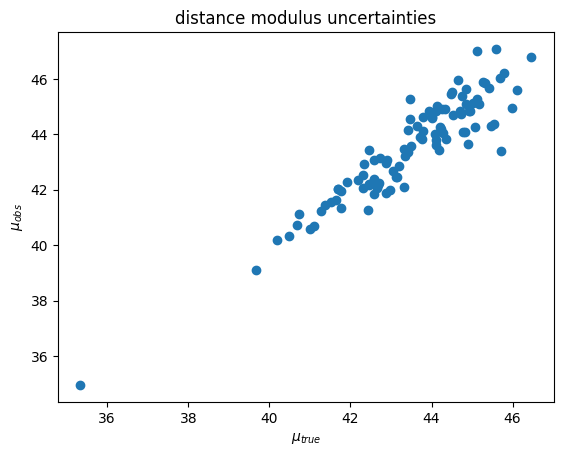

In [11]:
plt.scatter(mus_true, mus_obs)
plt.xlabel(r'$\mu_{true}$')
plt.ylabel(r'$\mu_{obs}$')
plt.title('distance modulus uncertainties')

Text(0.5, 1.0, 'observed Hubble diagram')

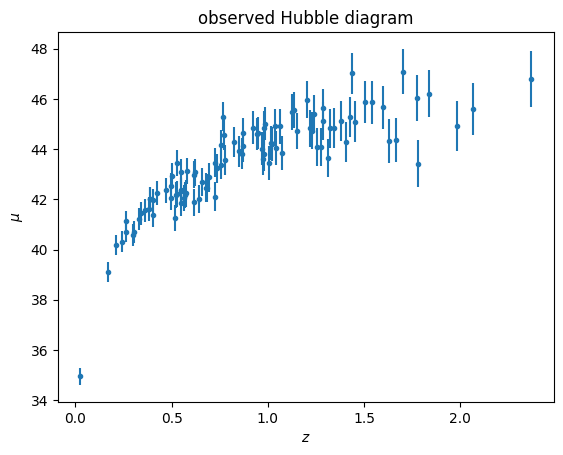

In [12]:
plt.errorbar(zs_est, mus_obs, #xerr=scatter_lsst*(1.+zs_est), 
             yerr=mus_err, fmt='.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.title('observed Hubble diagram')

### Models

In [13]:
z_grid = np.linspace(z_min, z_max, 100)
est_H0 = prior_H0.rvs()
est_Om0 = prior_Om0.rvs()
est_cosmo = apcosmo.FlatLambdaCDM(H0=est_H0, Om0=est_Om0)
mus_est = est_cosmo.distmod(z_grid).value

/home/aimalz/Documents/Meetings/22F_DSFP_NW/ve3_dsfp/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1284: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


In [14]:
prior_w0 = sps.norm(loc=0.89, scale=0.13)
new_cosmo = apcosmo.wCDM(est_H0, est_Om0, 1.-est_Om0, w0=prior_w0.rvs())
mus_new = new_cosmo.distmod(z_grid).value

Text(0.5, 1.0, 'observed Hubble diagram with models')

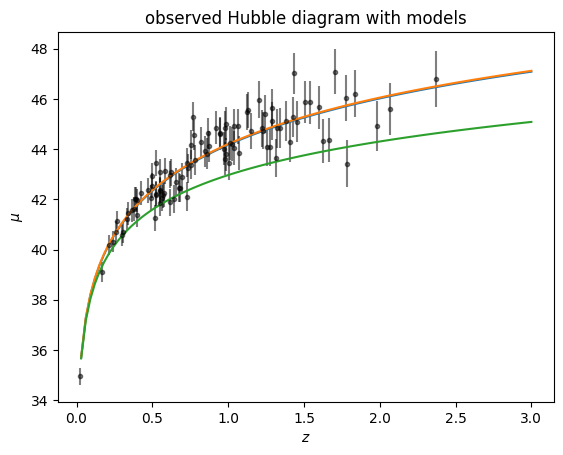

In [15]:
plt.errorbar(zs_est, mus_obs, #xerr=scatter_lsst*(1.+zs_est), 
             yerr=mus_err, fmt='.', c='k', alpha=0.5)
plt.plot(z_grid, true_cosmo.distmod(z_grid).value, label='true model')
plt.plot(z_grid, mus_est, label='estimated model')
plt.plot(z_grid, mus_new, label='misspecified model')
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.title('observed Hubble diagram with models')

## Frequentist model comparison: Goodness-of-fit & hypothesis testing

### Problem 0a

Implement a function calculating the reduced $\chi^{2} = \sum_{i=1}^{N}\left(\frac{y_{i} - M_{i}(\theta)}{\sigma_{i}}\right)^{2}$ and calculate the $\chi^{2}$ for the two models.
Hint: use the function you wrote yesterday.

In [ ]:
# def chi_sq(model, xvals, yvals_obs, yerrs_obs):
#     """
#     Calculates the $chi^{2}$ statistic
    
#     Parameters
#     ----------
#     model: function
#         function taking xvals and producing yvals
#     xvals: array, float
#         values of the independent variable at which yvals_obs were measured
#     yvals_obs: array, float
#         values of the dependent variable at xvals
#     yerrs_obs:
#         errors on dependent variable observations
        
#     Returns
#     -------
#     chi_sq: float
#         value of the $\chi^{2}$ statistic
#     """

In [ ]:
# print(chi_sq(est_cosmo, zs_est, mus_obs, mus_err))
# print(chi_sq(new_cosmo, zs_est, mus_obs, mus_err))

# make a grid of values for cosmological parameters, plot both on same axes at all points

### Problem 0b

Minimize the $\chi^{2}$ to find the maximum likelihood estimator of the cosmological parameters.
Hint: use `scipy.optimize.minimize()`

In [ ]:
# hint: use scipy.optimize.minimize()

### Hypothesis test

(Apologies, I didn't leave time to flesh this out!
But you can do a $p$-test on the $\chi^{2}$ likelihood and see how different models or parameter choices perform.)

### Problem 0c

Take MCMC samples under each of the models assuming the Gaussian $\chi^{2}$ likelihood and a prior of your choice (e.g. from a recent paper on arXiv) to sample the posterior.
Hint: use what you wrote earlier today.

## Model comparison

There are a number of information criteria used to compare models, which are covered in Adam Mantz's notebook from a previous year.
To be honest, I've never seen anyone use them in the literature in cosmology at least, so I'll refer you there if you want to see them in action on toy data.

## Fisher information

When there are multiple dimensions of parameters, they may not be independent with respect to the $\chi^{2}$ likelihood, and their degeneracies can be described by the Fisher matrix $F_{ij} = \frac{1}{2}\frac{\partial^{2}}{\partial\theta_{i}\partial\theta_{j}}\chi^{2}(M, \theta)$.
We'll explore the Fisher matrix for the cosmological parameters from SNIa data, following [code](https://github.com/COINtoolbox/RESSPECT/blob/master/resspect/cosmo_metric_utils.py) developed by [Kara Ponder](https://medium.com/noodle-labs-the-future-of-ai/supernovae-to-customer-success-a-data-science-journey-499c94593189) for the [REcommendation System for SPECTroscopic follow-up (ReSSPect)](https://cosmostatistics-initiative.org/resspect/), but I hear there's an out-of-the-box version already in `scipy`.

### Problem 1a

Implement a function empirically calculating the Fisher matrix $F$.
When is $F^{-1}_{i,j} = \sigma_{i}\sigma_{j}$? (When likelihood is Gaussian)

In [41]:
def assign_cosmo(cosmo, model=[70, 0.3, 0.7, -0.9, 0.0]):
    """Define a new cosmology model.
    Parameters
    ----------
    cosmo: astropy.cosmology Cosmology Object
        Assumes original cosmology was astropy.cosmology.w0waCDM.
    model: list (optional)
        Cosmology parameters: [H0, Om, Ode, w0, wa].
        Default is [70, 0.3, 0.7, -0.9, 0.0].
        Hard code Ob0 (Omega baryons) = 0.022
    Returns
    -------
    newcosmo: astropy.cosmology Cosmology Object
        New Cosmology Object with updated cosmology parameters
    """

    ob0 = 0.022
    om0 = model[1]
    ode0 = model[2]

#     newcosmo = cosmo.clone(name='temp cosmo', H0=model[0], Ob0=ob0,
#                            Om0=om0, Ode0=ode0, w0=model[3], wa=model[4])
    
    newcosmo = apcosmo.w0waCDM(model[0], ob0, om0, ode0, model[3], model[4])

    return newcosmo

def fisher_results(redshift, mu_err, 
                   param_names=['hubble', 'omega_m', 'omega_de', 'w0', 'wa'], 
                   fid_params=[70., 0.3, 0.7, -1.0, 0.]):
    """Computes the Fisher Matrix. Assumes we only care about Om and w0.
    TBD: make stepvec an input.
    TBD: Priors as inputs?
    Parameters
    ----------
    redshift: list [float]
        Redshift.
    mu_err: list [float]
        Error in distance modulus.
    Returns
    -------
    sigma: list
        Error/Standard deviation of Om and w0, respectively.
    covmat: np.array [2, 2]
        Covariance matrix of Om and w0. Om is first row, w0 is second.
    """
    if any(np.array(redshift) < 0):
        raise ValueError('Redshift must be greater than zero! Galaxies must be moving away.')

    stepvec = np.array([0, 0.001, 0.00, 0.1, 0., 0.0, 0.0, 0.0])

    model = fid_params
    names = param_names

    step_inds = np.where(stepvec)[0]
    fishermu, deriv = fish_deriv_m(redshift, model, stepvec)

    cov = np.diag(mu_err**2)
    inv_cov = np.diag(1./mu_err**2.)

    # Initialising the Fisher Matrix
    FM = np.zeros((len(step_inds), len(step_inds), len(mu_err) ))


    # Compute the Fisher matrix
    for i in range(len(step_inds)):
        # loop over variables
        for j in range(len(step_inds)):
            # loop over variables
            for k in range(len(redshift)):
                # loop over redshifts
                invcov = inv_cov[k,k]
                FM[i,j,k] = np.dot(np.dot(deriv[k, step_inds[i]], invcov), deriv[k, step_inds[j]])

    # sum over the redshift direction
    fishmat = np.sum(FM,axis=2)

    # Compute the prior matrix
    prior_vec = np.array([0.1, 0.02, 0.0006, 0.2, 0.2])
    priormat = np.diag(1./prior_vec[step_inds]**2.)

    final_FM = fishmat + priormat
    covmat = np.linalg.inv(final_FM)
    sigma = np.sqrt(covmat.diagonal())

    return sigma, covmat

def fish_deriv_m(redshift, model, step, screen=False):
    """Calculates the derivatives and the base function at given redshifts.
    Parameters
    ----------
    redshift: float or list
        Redshift where derivatives will be calculated.
    model: list
        List of cosmological model parameters.
        Order is [H0, Om, Ode, w0, wa].
    step: list
        List of steps the cosmological model parameter will take when determining
         the derivative.
        If a given entry is zero, that parameter will be kept constant.
        Length must match the number of parameters in "model" variable.
    screen: bool (optional)
        Print debug options to screen. Default is False.
    Returns
    -------
    m: list
        List of theoretical distance modulus (mu) at a given redshift from
         the base cosmology.
    m_deriv: list [len(redshift), len(model)]
        List of parameter derivatives of the likelihood function
         at given redshifts.
    """
    
    Ob0 = 0.022
    Om0 = model[1]
    Ode0 = model[2]
    cosmo = apcosmo.w0waCDM(model[0], Ob0, Om0, Ode0, model[3],model[4])

    cosmo=assign_cosmo(cosmo, model)

    m = []
    m_deriv = []
    c = apconst.c.to('km/s')
    base_theory = cosmo.distmod(redshift)
    m = base_theory.value
    step_inds = np.where(step)[0] # look for non-zero step indices
    deriv = np.zeros((len(base_theory), len(model)))

    if (step_inds.size==0):
        print('No steps taken, abort')
        exit

    else:
        if screen:
            print('\n')
            print('Computing Fisher derivatives...')

        for i, stepp in enumerate(step_inds):
            if screen:
                print('we are stepping in :', model[stepp], 
                      ' with step size', step[stepp])
            cosmo = assign_cosmo(cosmo, model)

            theory = np.zeros((len(base_theory),2))
            for count,j  in enumerate([-1,1]):

                tempmodel = list(model)
                tempmodel[stepp] = model[stepp] + j*step[stepp]
                c = apconst.c.to('km/s')
                cosmo = assign_cosmo(cosmo, tempmodel)
                tmp = cosmo.distmod(redshift)
                theory[:,count] = tmp

            deriv[:,stepp] = (theory[:,1] - theory[:,0])/(2.*step[stepp])

    m_deriv = deriv

    return m, m_deriv

In [50]:
fishmat = fisher_results(zs_est, mus_err)
fishmat

(array([0.01912519, 0.18859601]),
 array([[ 0.00036577, -0.00035618],
        [-0.00035618,  0.03556846]]))

### Problem 1b

Building on the above, do the same for another cosmology model (`apcosmo.FlatLambdaCDM`) or allowing other parameters to vary.

### Problem 1c

Implement a function that plots error ellipses given a Fisher matrix.
This is a useful thing to have around -- I'm still recycling code I wrote to do this in grad school!

In [ ]:
def fisher_to_ellipse(fisher):
    diag_elems = np.diag(fisher)
    term1 = (diag_elems[:, np.newaxis] + diag_elems[np.newaxis, :]) / 2.
    term2 = np.sqrt((diag_elems[:, np.newaxis] - diag_elems[np.newaxis, :])**2 / 4. + fisher * fisher.T)
    a = np.sqrt(term1 + term2)
    b = np.sqrt(term1 - term2)
    t = np.arctan((fisher + fisher.T) / np.abs(diag_elems[:, np.newaxis] - diag_elems[np.newaxis, :])) / 2.
    try:
        assert(np.all(a >= 0.))
    except:
        print(a)
    try:
        assert(np.all(b >= 0.))
    except:
        print(b)
    return(a, b, t)

def plot_ellipse(semimajor, semiminor):
    

### Problem 1c

Implement the AIC for the MLE.
Then calculate it for the two cosmological models.

### Problem 1d

